La parte interesante de MESF es eliminar la autocorrelación implícita de los datos debido a la posición geográfica (en regresión lineal se supone que las observaciones son indepenientes). 

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append(
    "/Users/mateo/Documents/Máster Big Data/TFM/codes/urbana-barcelona-master/src"
)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

In [5]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2023  # ALLOWED_YEARS = [2017, 2018, 2023]
MONTH = 12

OUTPUT_WARNINGS = False
SAVE_FIGS = False
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

# Number of selected variables in these categories
K_EDUCATION = 1
K_AGE = 2
K_NATIONALITY = 2
K_RENT = 1
K_POI = 10

In [6]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

# Parameter Check

In [7]:
ALLOWED_YEARS = [2017, 2018, 2023]

if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

In [8]:
# Create folders to store the data
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_SVR = DIR_MONTH / "05_svr"

if SAVE_FIGS:
    folder_list = [
        DIR_SVR,
        DIR_SVR / "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [9]:
PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

In [10]:
PATH_TO_FILE = DIR_MONTH / "01_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "01linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

# Initial visualizations

In [11]:
sect = pd.read_csv(
    DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH),
)

sect.set_index("Tag", inplace=True)

sect.drop(
    ["N_district", "N_neighbourhood", "N_section"],
    axis=1,
    inplace=True,
)
sect.drop(["Percentage_Age_25_39"], axis=1, inplace=True)  # Duplicate


sect.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Airbnb_Location_Score             151
Airbnb_Price_Person               119
Airbnb_Price                      119
Rent_Area_Flats                    18
Rent_Price_Total_Flats             18
Rent_Price_Meter_Flats             18
Rent_Number_Flats                  10
Nationality_Venezuela               0
Nationality_Dominican_Republic      0
Nationality_Ecuador                 0
dtype: int64

In [12]:
geo_info = gpd.read_file(
    DIR_DATA / "interim/sections_geo.json",
)

geo_info.set_index("Tag", inplace=True)

geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

In [13]:
# y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1)).flatten()
y = sect[VARIABLE_TO_PREDICT]
X = sect.drop(
    [
        "Airbnb_Number",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
    ],
    axis=1,
)

print(X.shape)

coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

(1068, 84)


In [14]:
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

id_max_airbnb = geo_info[VARIABLE_TO_PREDICT].idxmax()

print("Area with maximum value: " + str(id_max_airbnb))

Area with maximum value: 02_077


## Target variable

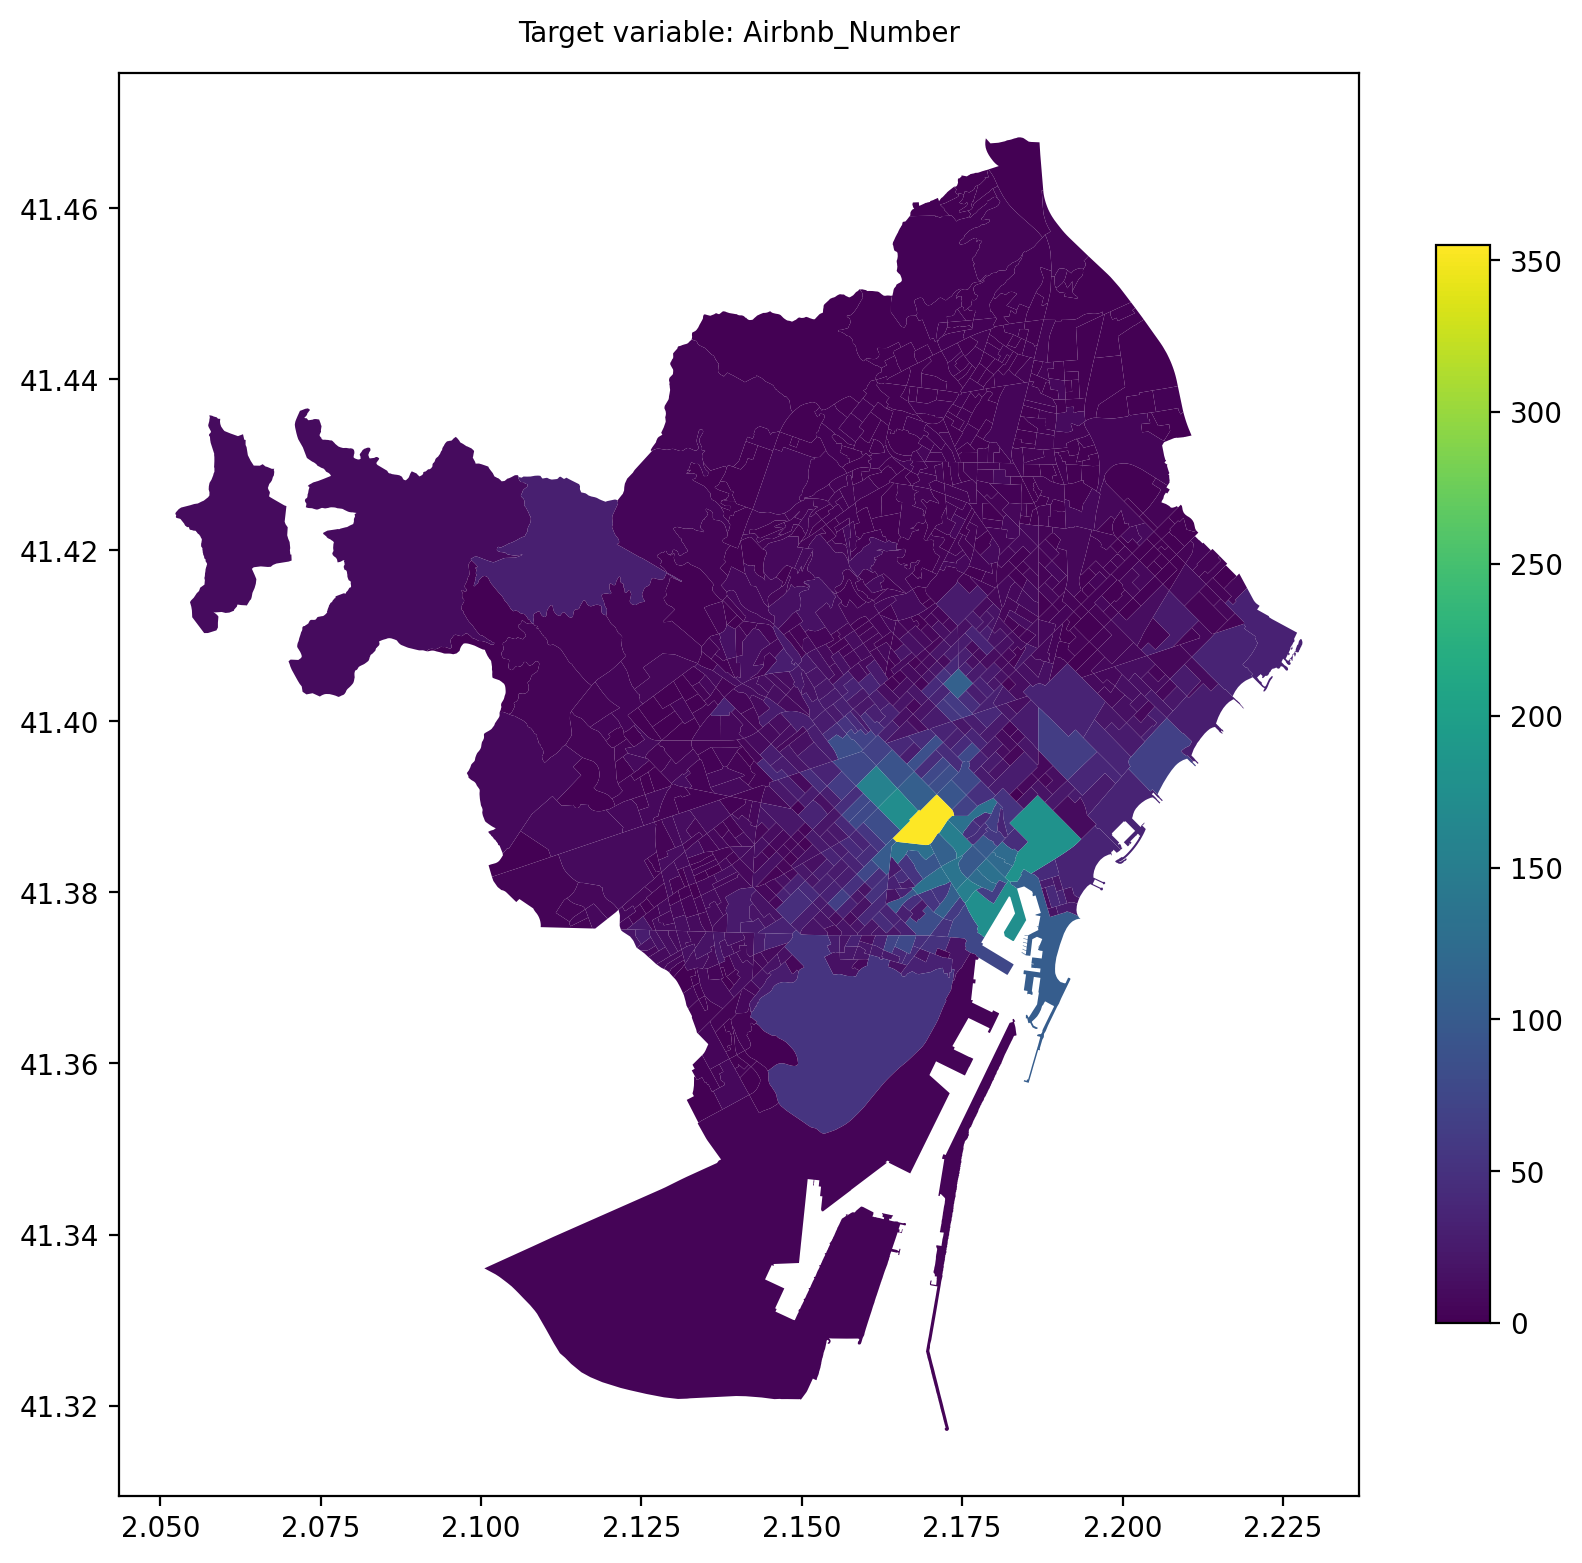

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=10, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "target_variable.svg", format="svg")

plt.show()

This plot shows the geographical distribution of the number of Airbnbs in Barcelona. It can be seen that there is a high concentration in the city center, and that it is apparently reduced when increasing the distance. In addition, the regions with a lower number of Airbnbs show a low variability.

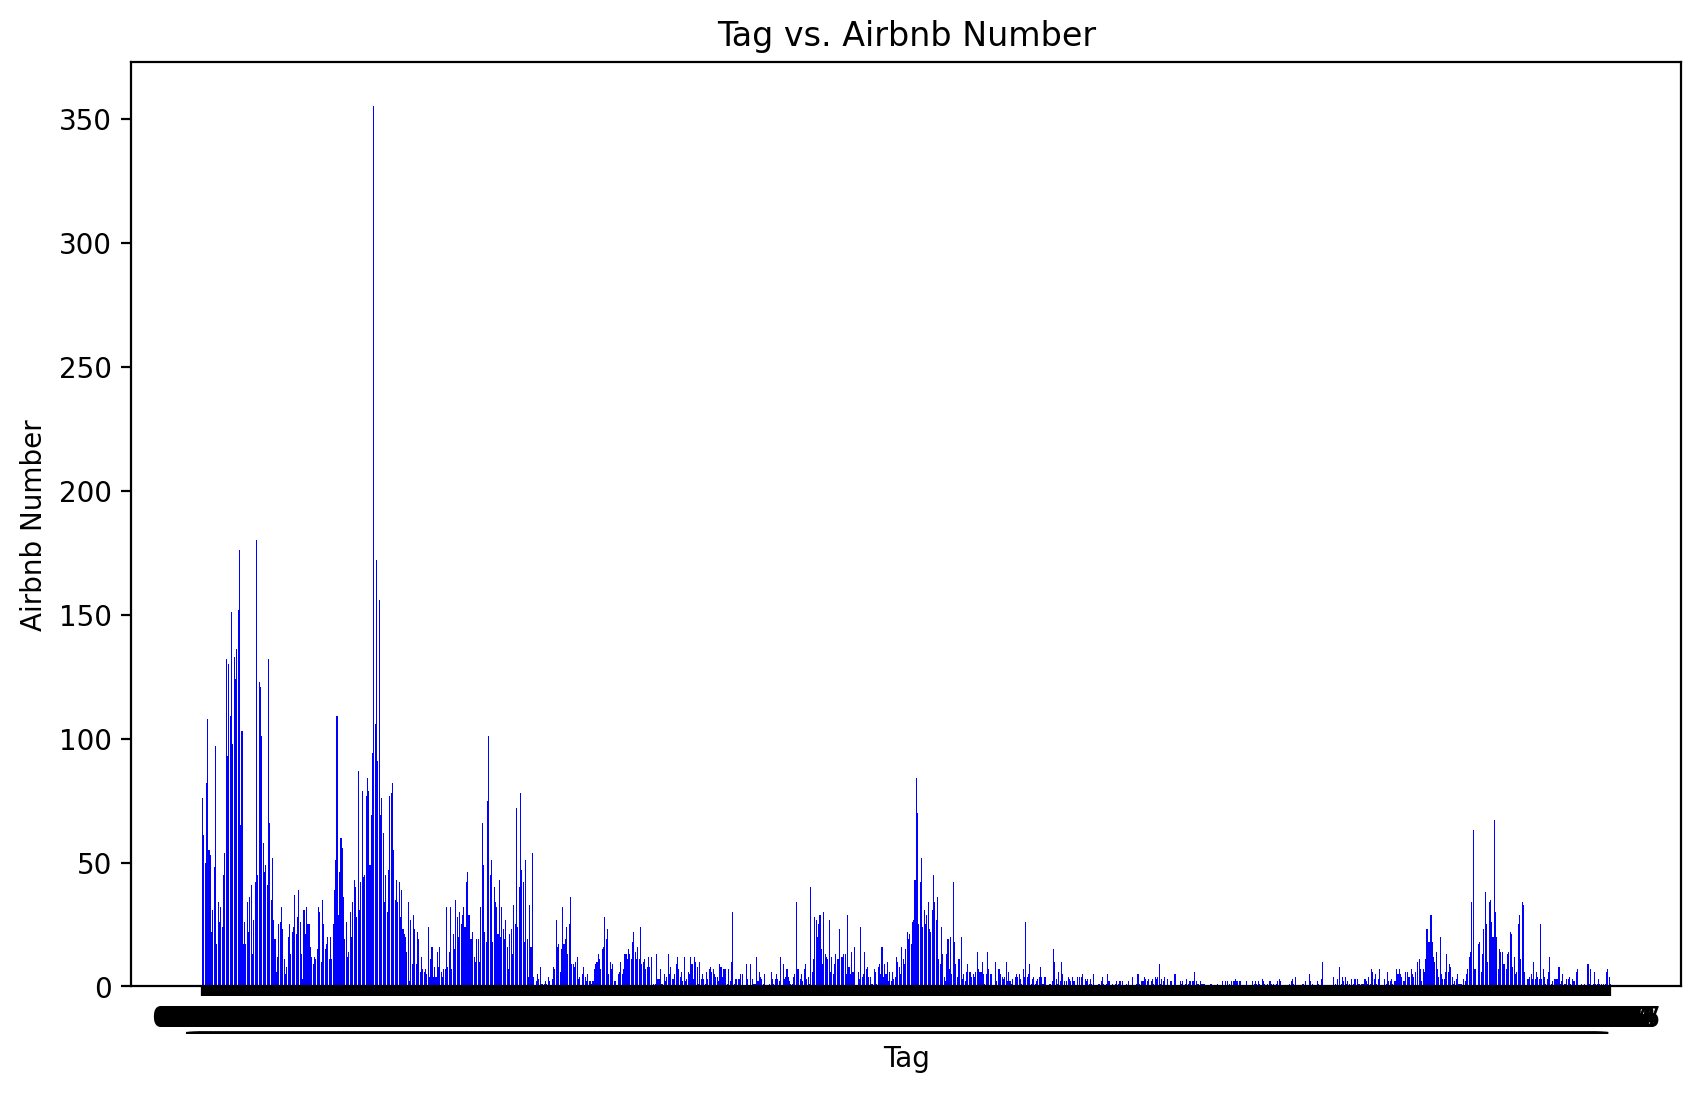

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(geo_info.index, geo_info["Airbnb_Number"], color="b")
plt.xlabel("Tag")
plt.ylabel("Airbnb Number")
plt.title("Tag vs. Airbnb Number")
plt.show()

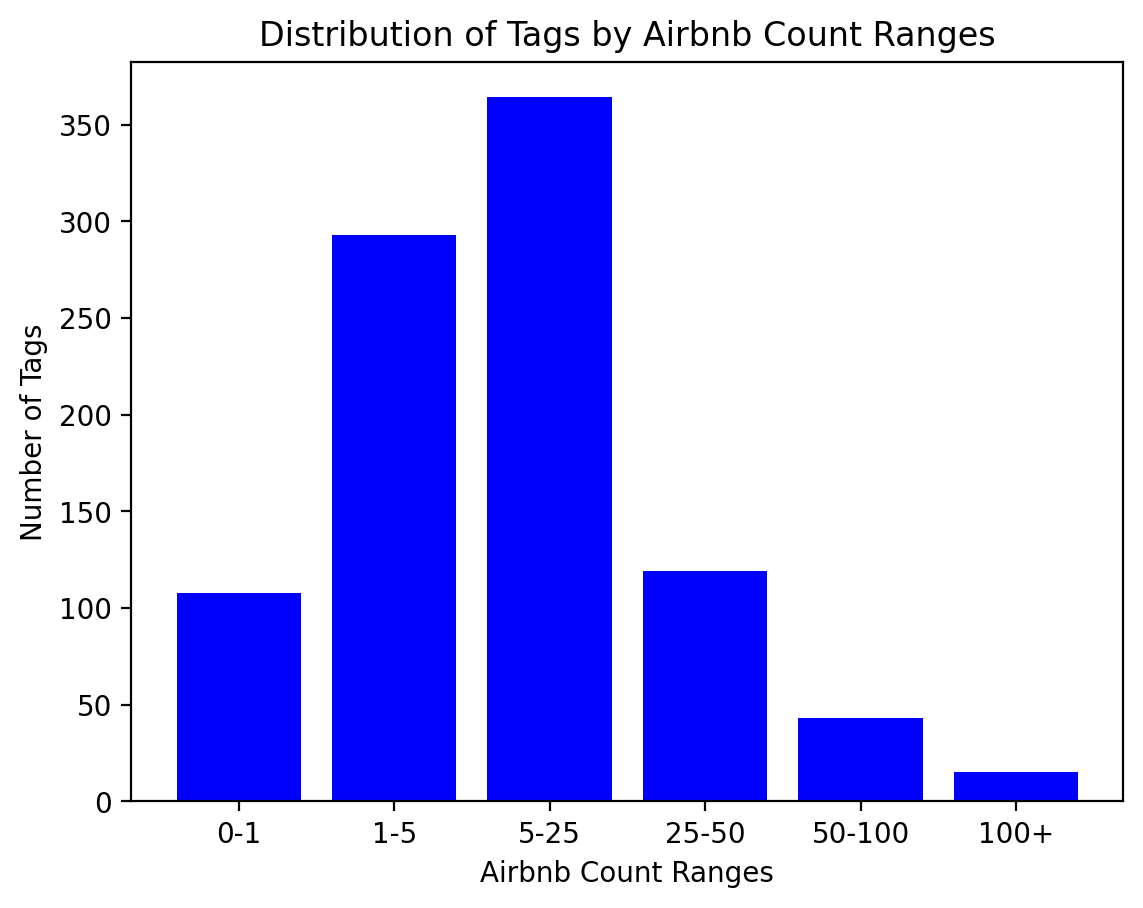

In [17]:
bins = [0, 1, 5, 25, 50, 100, 150]
labels = ["0-1", "1-5", "5-25", "25-50", "50-100", "100+"]

geo_info_rep = geo_info
geo_info_rep["Tag"] = geo_info_rep.index

geo_info_rep["Airbnb_Range"] = pd.cut(
    geo_info["Airbnb_Number"], bins=bins, labels=labels
)

tag_counts = geo_info.groupby("Airbnb_Range")["Tag"].count()

plt.bar(tag_counts.index, tag_counts.values, color="b")
plt.xlabel("Airbnb Count Ranges")
plt.ylabel("Number of Tags")
plt.title("Distribution of Tags by Airbnb Count Ranges")
plt.show()  # Display the plo

## NaNs

In [18]:
# define the colormap
cmap = plt.cm.Accent_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
cmaplist[0] = "0.8"
# define the bins and normalize
bounds = np.linspace(0, 8, 9)
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

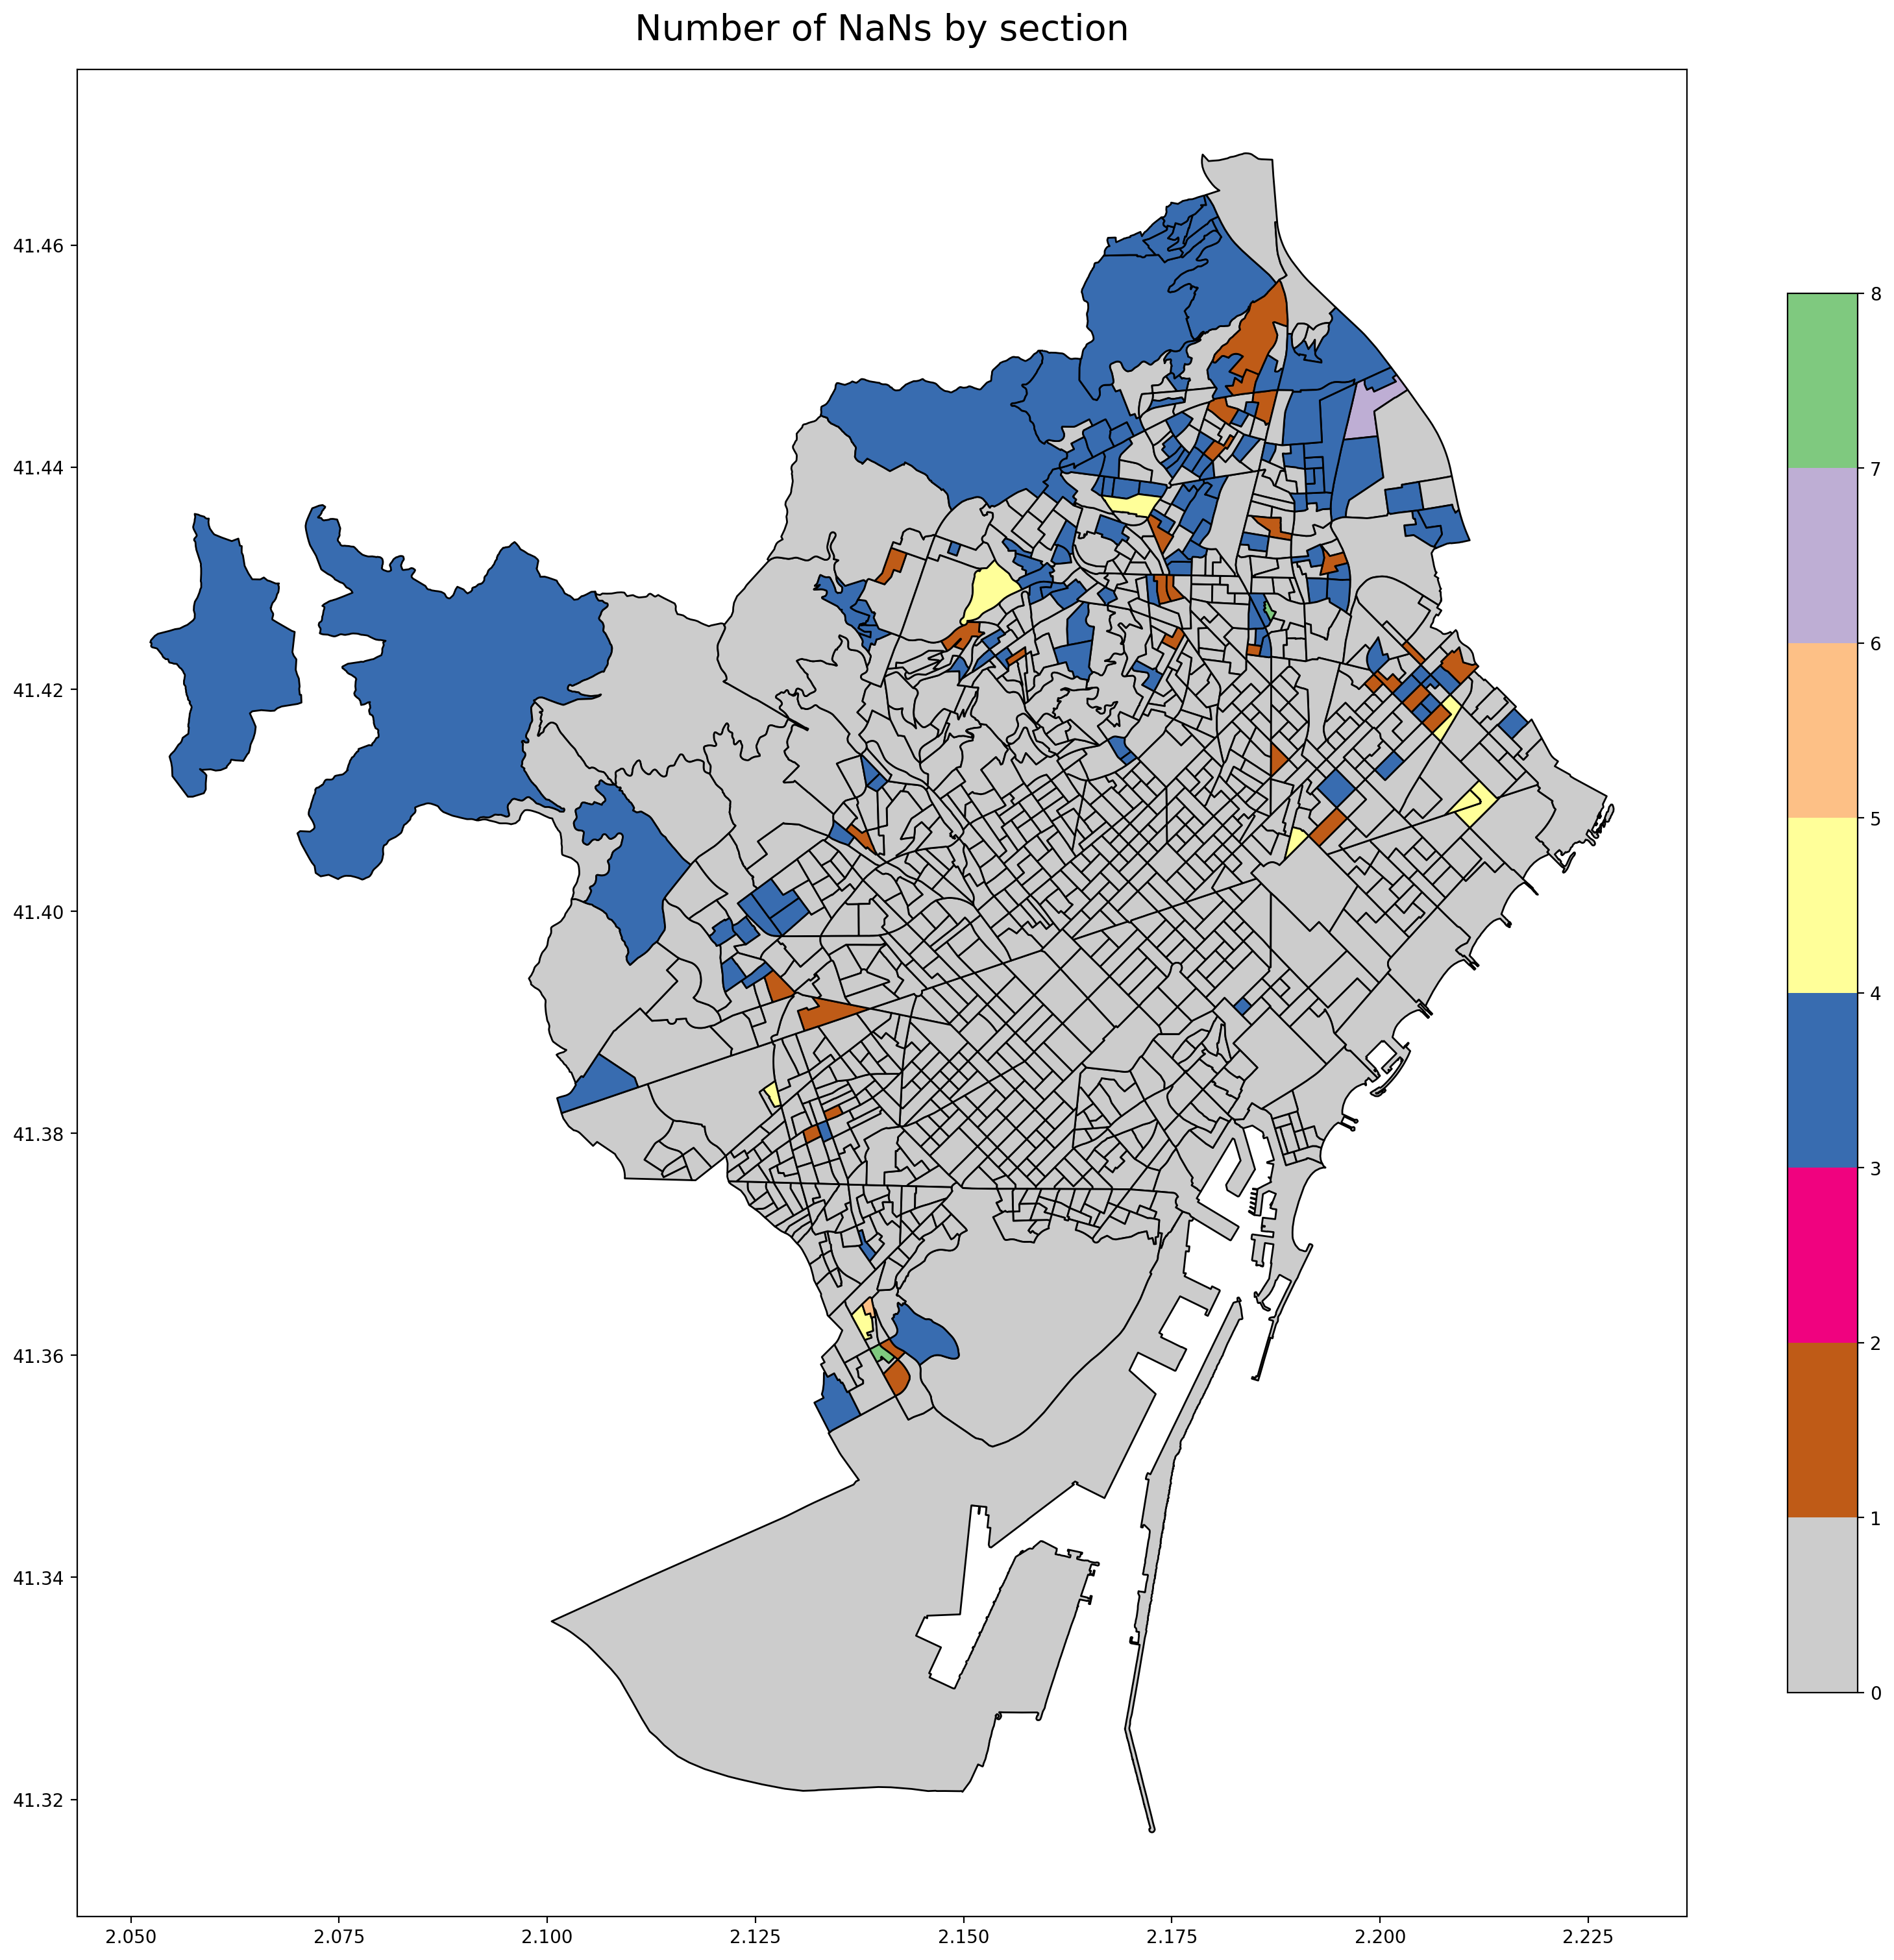

In [19]:
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor="black",
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "nans.svg", format="svg")

plt.show()

# Moran’s Eigenvector Spatial Filtering (MESF) linear regression

- Incluir expresión matemática del modelo -


In [20]:
from libpysal.weights import Queen, KNN, Gabriel
import networkx as nx

In [21]:
pd.set_option("display.max_columns", None)
# print(X.head())
# print(geo_info.head())
geo_info.head()

geometry  \
Tag                                                         
01_001  POLYGON ((2.17575 41.37827, 2.17552 41.37865, ...   
01_002  POLYGON ((2.17510 41.37905, 2.17470 41.37951, ...   
01_003  POLYGON ((2.17220 41.37692, 2.17206 41.37696, ...   
01_004  POLYGON ((2.16962 41.37847, 2.16962 41.37847, ...   
01_005  POLYGON ((2.17366 41.38071, 2.17330 41.38113, ...   

                        centroid  Airbnb_Number     Tag Airbnb_Range  
Tag                                                                   
01_001  POINT (2.17722 41.37432)             76  01_001       50-100  
01_002  POINT (2.17391 41.37793)             61  01_002       50-100  
01_003  POINT (2.17199 41.37576)             50  01_003        25-50  
01_004  POINT (2.16924 41.37642)             82  01_004       50-100  
01_005  POINT (2.17277 41.37884)            108  01_005         100+

## Spatial Weight Matrices 

### Queen contiguity

In [22]:
def plot_spatial_weights(gdf, w, title):
    # Create a graph from the spatial weights matrix
    G = nx.Graph()
    for idx, neighbors in w.neighbors.items():
        for neighbor in neighbors:
            G.add_edge(idx, neighbor)

    # Get positions from centroids of the geodataframe
    pos = {
        idx: (gdf.geometry[idx].centroid.x, gdf.geometry[idx].centroid.y)
        for idx in G.nodes()
    }

    # Draw the network
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, node_size=50, node_color="blue", with_labels=False)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.show()

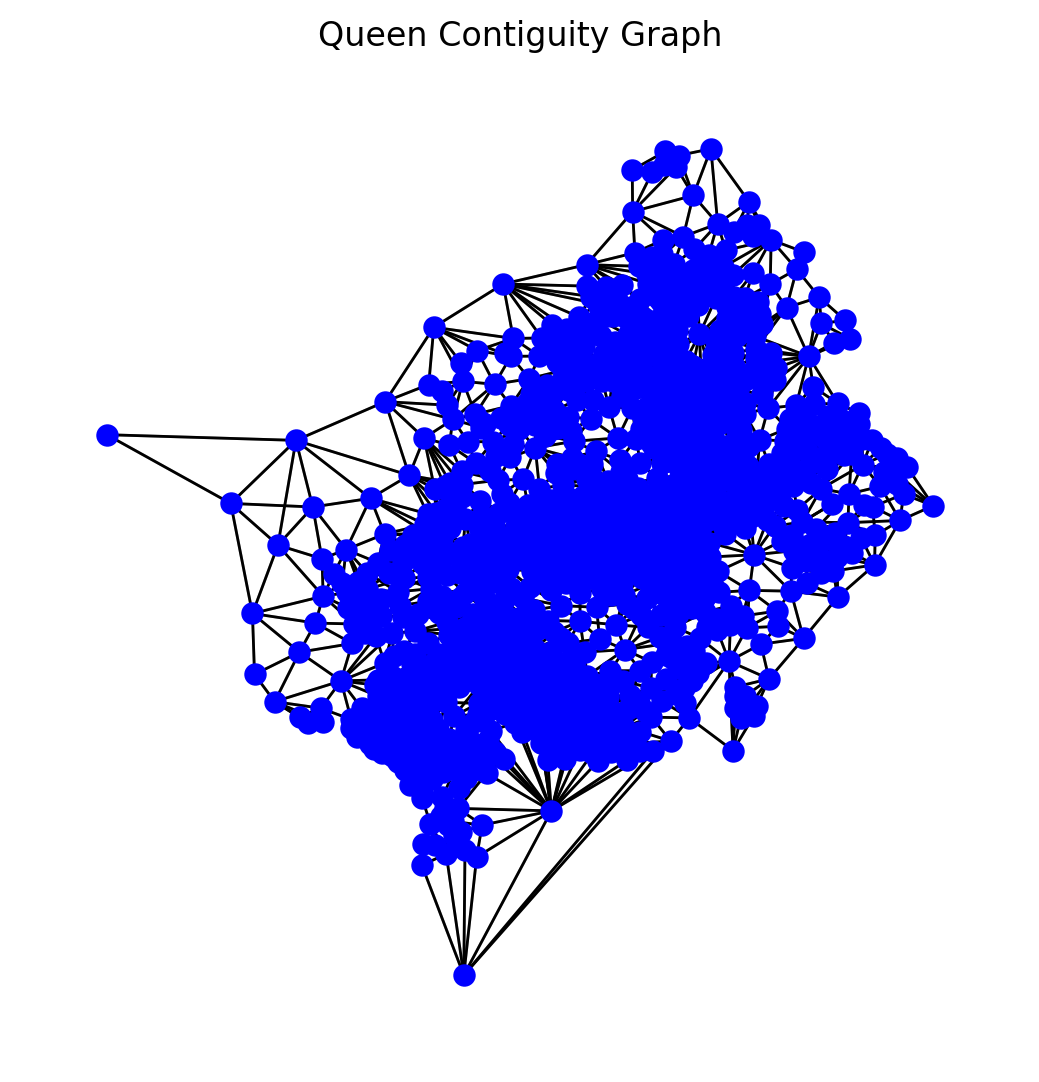

In [23]:
w_queen = Queen.from_dataframe(geo_info)

plot_spatial_weights(geo_info, w_queen, "Queen Contiguity Graph")

### K-nearest neighbor

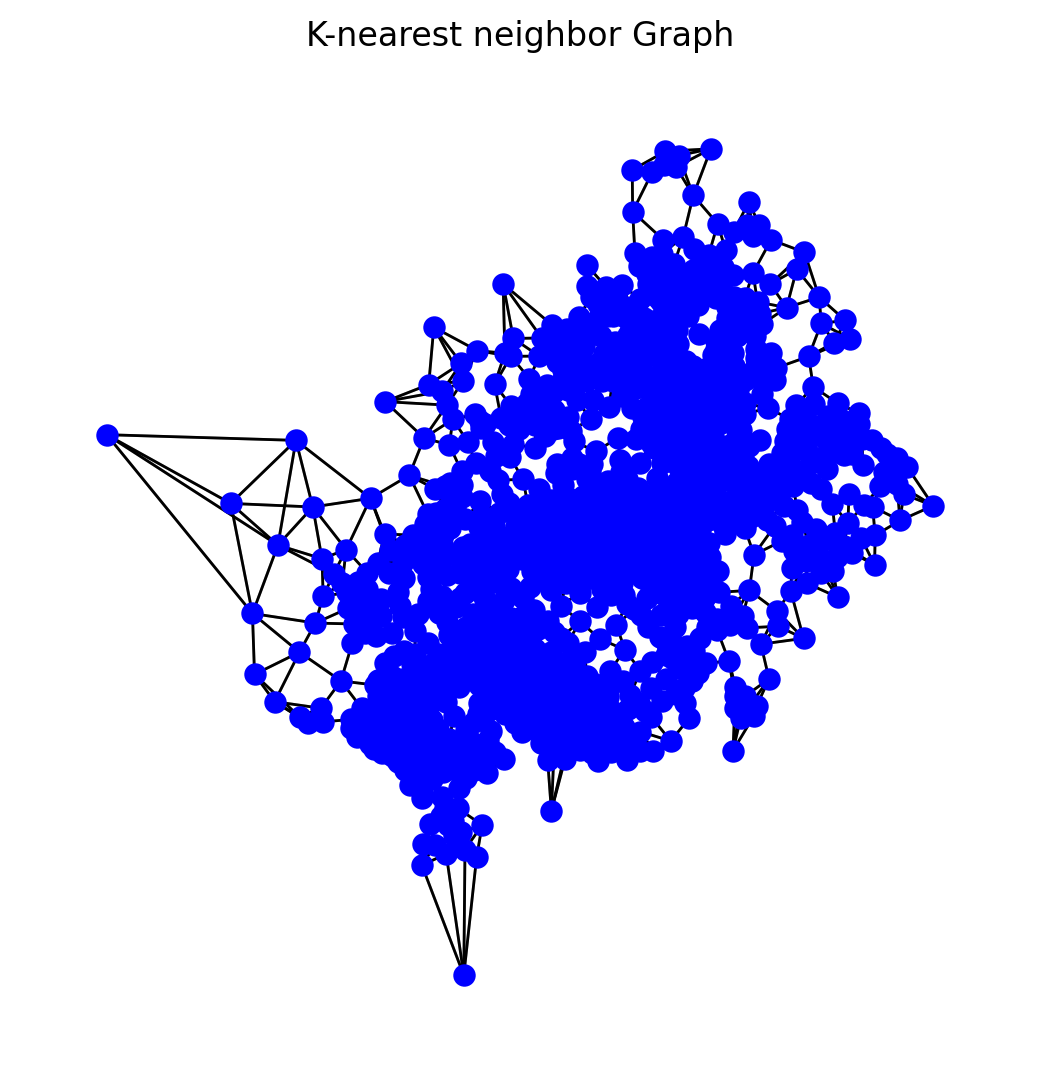

In [24]:
k = 4
w_knn = KNN.from_dataframe(geo_info, k=k)

plot_spatial_weights(geo_info, w_knn, "K-nearest neighbor Graph")

### Gabriel graph

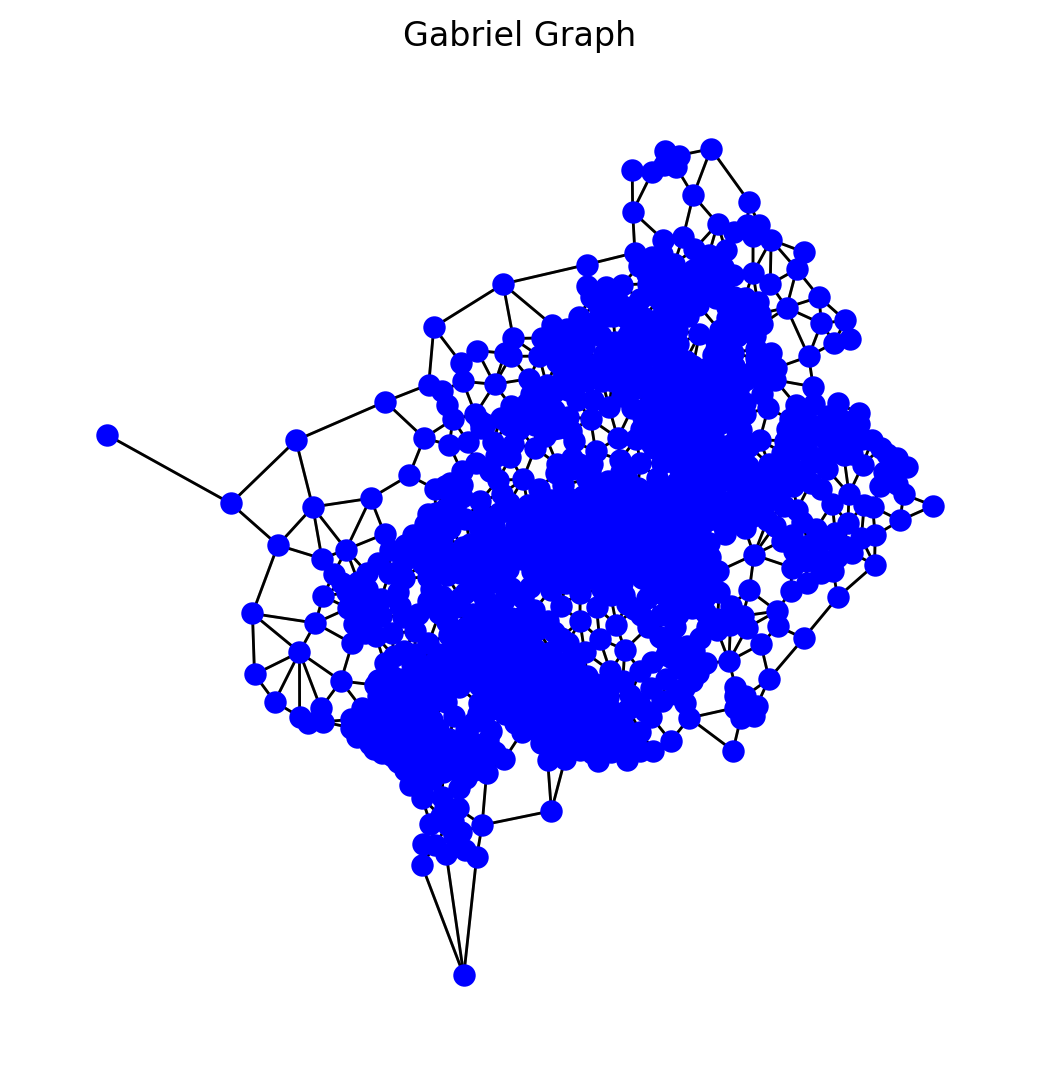

In [27]:
geo_info.set_index("Tag", inplace=True)

geo_info_points = geo_info.copy()
geo_info_points.set_geometry("centroid", inplace=True)
w_gabriel = Gabriel.from_dataframe(geo_info_points)

plot_spatial_weights(geo_info, w_gabriel, "Gabriel Graph")

In [31]:
w_gabriel.neighbors

{0: [1, 246, 28],
 1: [27, 0, 2, 4],
 2: [6, 1, 3, 245, 4, 246],
 3: [7, 242, 2, 223, 245],
 4: [1, 5, 2],
 5: [4, 26, 6, 18],
 6: [5, 18, 7, 2],
 7: [6, 8, 3, 9],
 8: [10, 223, 7, 9, 222],
 9: [8, 10, 12, 7],
 10: [8, 12, 9, 11, 222],
 11: [10, 219, 12, 14, 222],
 12: [14, 9, 11, 13, 10],
 13: [17, 12, 16, 18],
 14: [16, 218, 11, 15, 219, 12],
 15: [217, 14, 16, 218, 20],
 16: [13, 15, 17, 14],
 17: [19, 16, 20, 13],
 18: [13, 6, 19, 21, 5],
 19: [17, 21, 18, 130, 20],
 20: [130, 132, 15, 17, 19, 144],
 21: [130, 18, 22, 26, 19],
 22: [48, 21, 23],
 23: [45, 25, 27, 22, 26],
 24: [44, 45, 25, 29],
 25: [23, 27, 29, 24],
 26: [21, 23, 5, 27],
 27: [1, 23, 25, 26],
 28: [30, 38, 29, 0],
 29: [25, 24, 28],
 30: [28, 31],
 31: [36, 38, 37, 30, 32],
 32: [36, 31, 33],
 33: [32, 34, 36],
 34: [974, 975, 33, 35],
 35: [40, 37, 39, 34, 36],
 36: [32, 31, 33, 35, 37],
 37: [35, 39, 36, 38, 31],
 38: [31, 37, 28, 39],
 39: [38, 40, 35, 37],
 40: [41, 35, 39],
 41: [42, 974, 967, 971, 40, 968],


01_001


KeyError: '01_001'

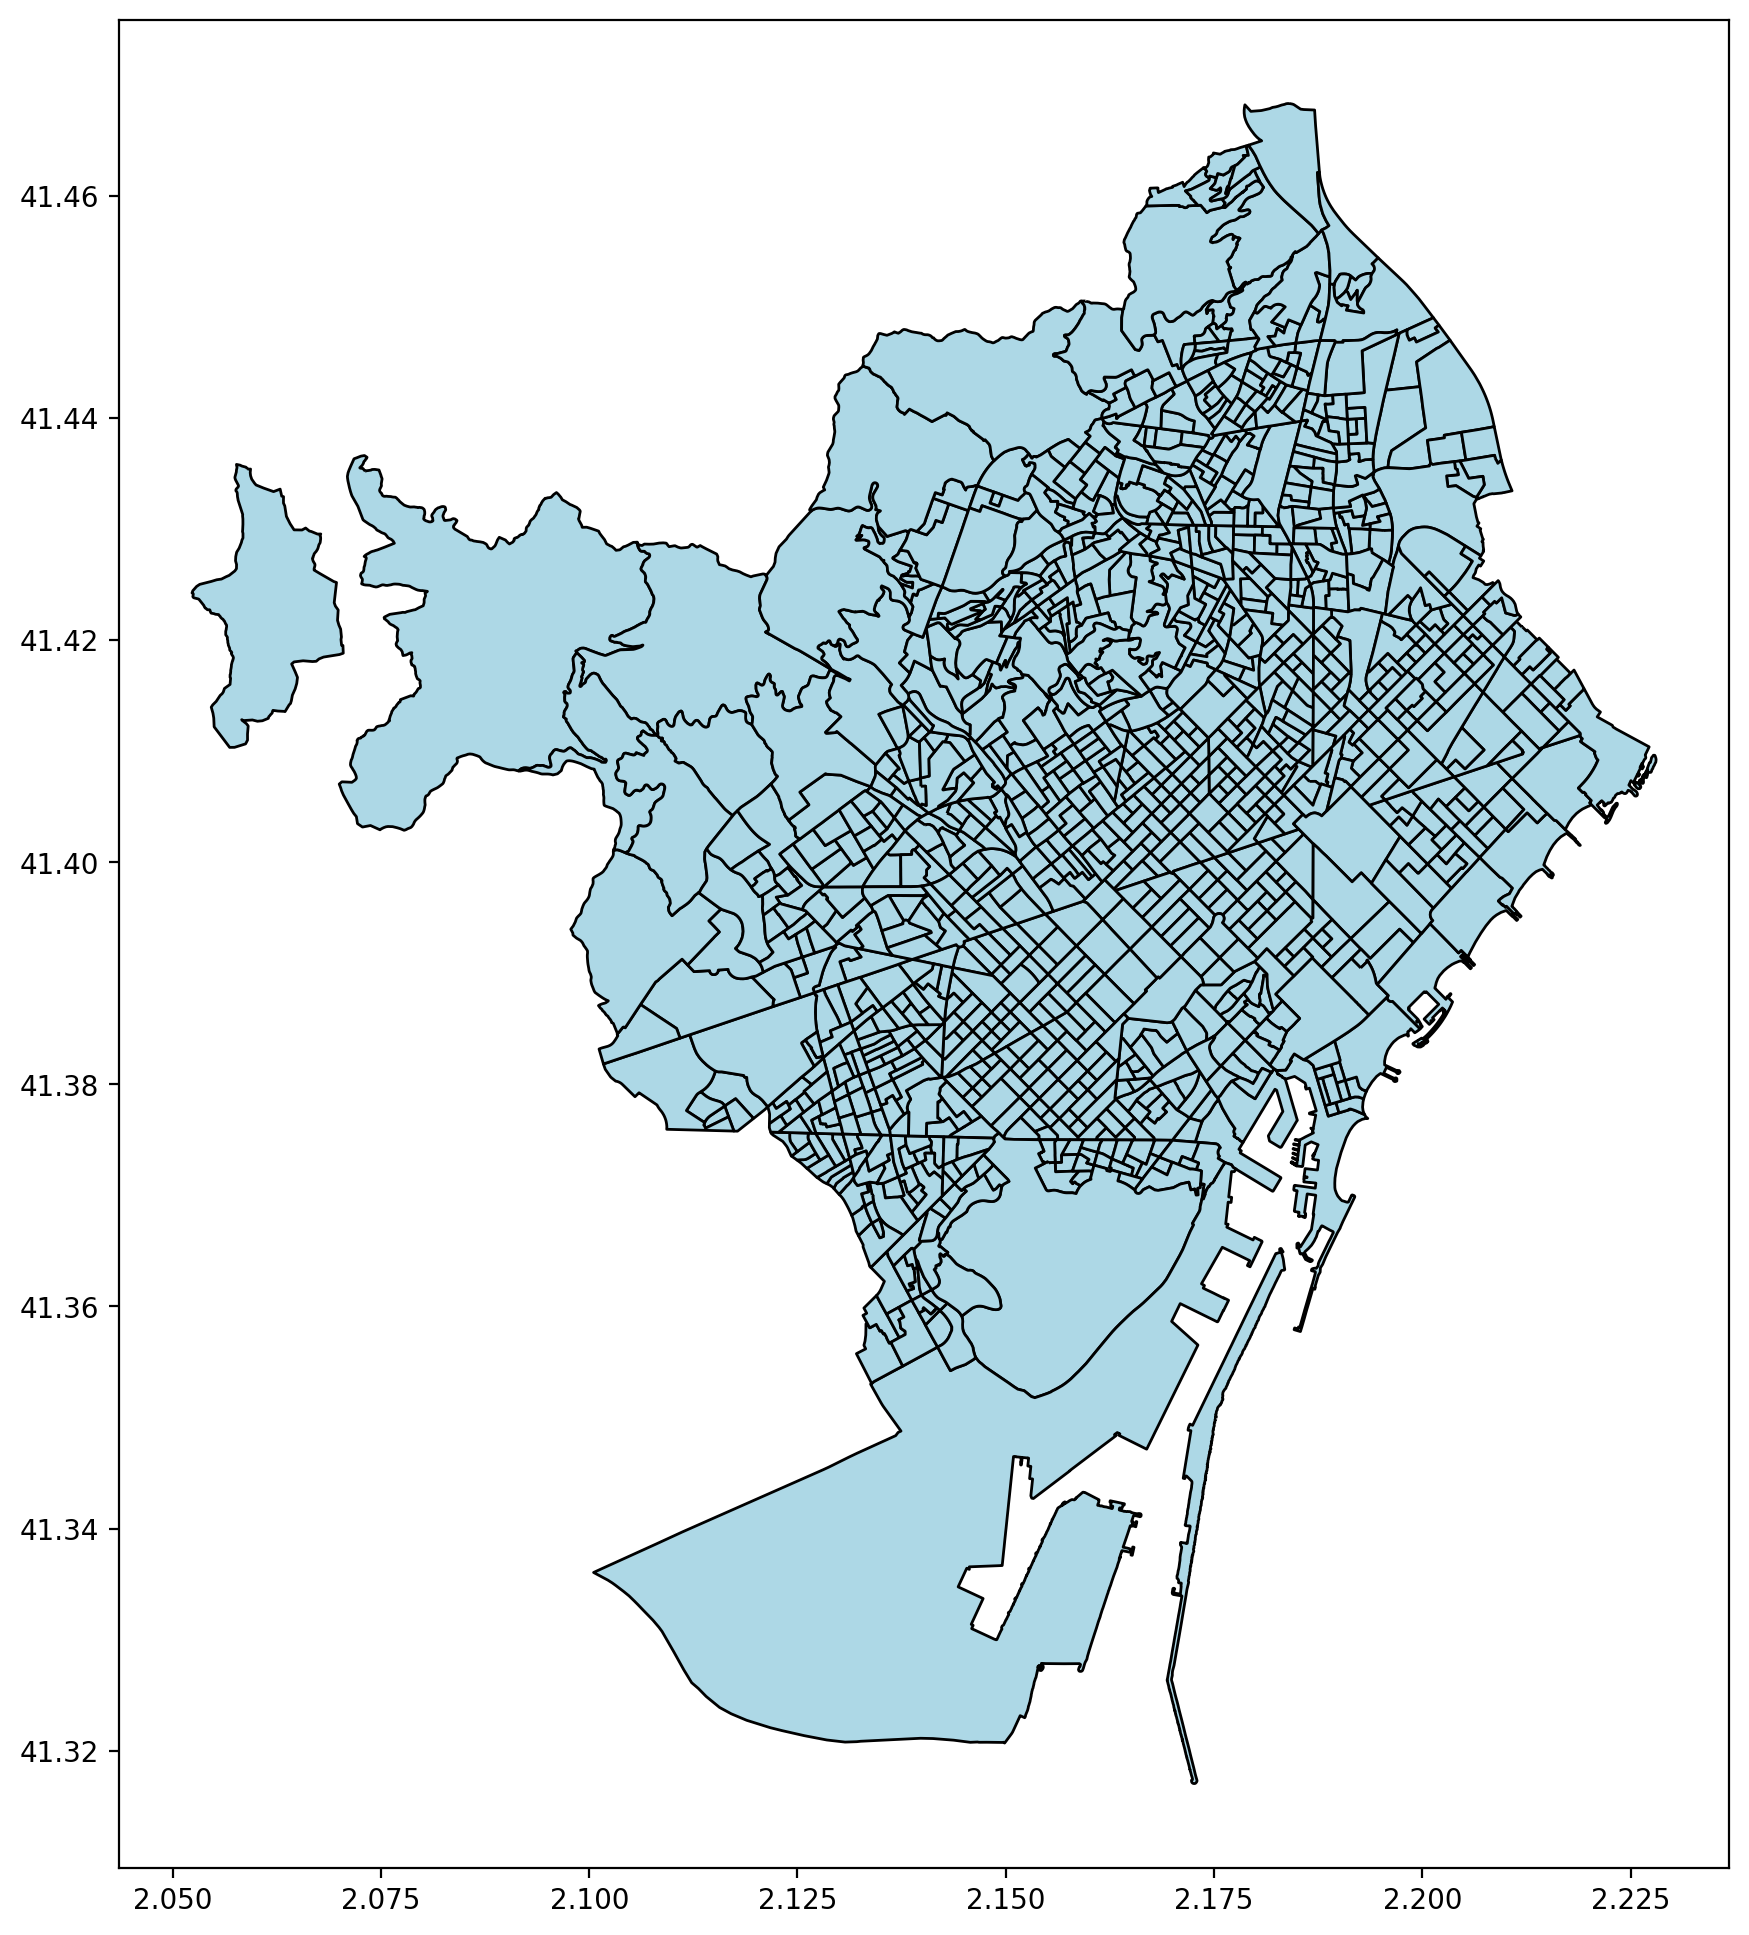

In [30]:
def plot_geographical_sections_with_graph(gdf, w, title):
    # Plot the geographical polygons
    fig, ax = plt.subplots(figsize=(12, 12))
    gdf.plot(ax=ax, color="lightblue", edgecolor="black")

    # Create a graph from the spatial weights matrix
    G = nx.Graph()
    pos = {}
    for idx, row in gdf.iterrows():
        G.add_node(idx)
        pos[idx] = (
            row["centroid"].x,
            row["centroid"].y,
        )  # Using centroid for node positions
        for neighbor in w.neighbors[idx]:
            G.add_edge(idx, neighbor)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color="red", ax=ax)

    # Draw the edges
    nx.draw_networkx_edges(G, pos, edge_color="gray", style="dashed", ax=ax)

    # Set plot title and show
    plt.title(title)
    plt.gca().set_aspect("equal", adjustable="datalim")
    plt.show()


plot_geographical_sections_with_graph(
    geo_info, w_gabriel, "Gabriel Graph with Geographical Sections"
)

## Moran's Eigenvectors

In [46]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh


def compute_morans_eigenvectors(w, num_eigs=10):
    # Convert the weights matrix to a sparse format
    w_matrix = csr_matrix(w.full()[0])
    # Compute the largest eigenvalues and corresponding eigenvectors
    # Adjust 'num_eigs' to the number of eigenvectors you want (it should be less than the number of areas)
    eigenvalues, eigenvectors = eigsh(
        w_matrix, k=num_eigs, which="LM"
    )  # 'LM' means largest magnitude
    return eigenvectors


eigenvectors_queen = compute_morans_eigenvectors(w_queen)
eigenvectors_knn = compute_morans_eigenvectors(w_knn)
eigenvectors_gabriel = compute_morans_eigenvectors(w_gabriel)

print(eigenvectors_queen)

[[-0.01376211  0.02399297 -0.01642115 ...  0.03357434 -0.00090524
  -0.052221  ]
 [-0.0275646   0.01889169 -0.0104434  ...  0.01748454  0.00052543
  -0.02923951]
 [-0.02162013  0.02095651 -0.01198229 ...  0.0261691  -0.00056394
  -0.04071787]
 ...
 [-0.05121624  0.01229625  0.00669291 ...  0.00652302  0.07964272
  -0.00073752]
 [-0.03076897  0.00741573  0.00417276 ...  0.00419822  0.05159434
  -0.00047878]
 [-0.02160164  0.03633333  0.03056798 ...  0.01562935  0.17786385
  -0.00146392]]


## Regression Model 

In [39]:
X.head()

Distance_Center  POI_Daily_Food  POI_Daily_Others  \
Tag                                                         
01_001         1.532922               6                 1   
01_002         1.060772               3                 2   
01_003         1.262231               9                 3   
01_004         1.180517              13                 4   
01_005         0.937494              20                 4   

        POI_House_Equipment  POI_Clothing  POI_Culture  POI_Vehicles  \
Tag                                                                    
01_001                    0             0            2             0   
01_002                    1             2            1             0   
01_003                    1             2            3             0   
01_004                    8             2            5             0   
01_005                    2             2           38             0   

        POI_State_Agents  POI_Education  POI_Finances  POI_Restaurants_Hotels  \
Tag                                                                             
01_001                 0              4             0                      33   
01_002                 0              2             0                      19   
01_003                 0              5             2                      20   
01_004                 2              3             3                      36   
01_005                 0              0             1                      42   

        POI_Health  POI_Souvenirs_Thrift_Store  POI_Car_Parks  POI_Esthetics  \
Tag                                                                            
01_001           2                           8              1              1   
01_002           0                           3              0              5   
01_003           3                           1              2              3   
01_004           1                           3              1              9   
01_005           1                          15              1             11   

        POI_Sports  POI_Religion  POI_Administration  \
Tag                                                    
01_001           1             1                   4   
01_002           0             0                   0   
01_003           1             0                   1   
01_004           1             2                   3   
01_005           0             0                   2   

        Percentage_Gender_Female  Percentage_Age_0_14  Percentage_Age_15_24  \
Tag                                                                           
01_001                  0.464203             0.123172              0.087760   
01_002                  0.486604             0.101376              0.126720   
01_003                  0.458248             0.200466              0.130637   
01_004                  0.450767             0.122317              0.111414   
01_005                  0.460146             0.118053              0.112452   

        Percentage_Age_40_64  Percentage_Age_65_Plus  Household  \
Tag                                                               
01_001              0.318707                0.143957       2.52   
01_002              0.281680                0.133961       2.60   
01_003              0.291824                0.108525       3.23   
01_004              0.329472                0.100170       2.65   
01_005              0.326583                0.126239       2.45   

        Education_None  Education_Primary_School  Education_Middle_School  \
Tag                                                                         
01_001        0.011474                  0.211827                 0.248897   
01_002        0.023200                  0.220800                 0.251200   
01_003        0.012806                  0.296744                 0.256129   
01_004        0.010937                  0.227734                 0.246875   
01_005        0.015648                  0.246455                 0.

In [45]:
X_enhanced.head()

Distance_Center  POI_Daily_Food  POI_Daily_Others  \
01_001         1.532922             6.0               1.0   
01_002         1.060772             3.0               2.0   
01_003         1.262231             9.0               3.0   
01_004         1.180517            13.0               4.0   
01_005         0.937494            20.0               4.0   

        POI_House_Equipment  POI_Clothing  POI_Culture  POI_Vehicles  \
01_001                  0.0           0.0          2.0           0.0   
01_002                  1.0           2.0          1.0           0.0   
01_003                  1.0           2.0          3.0           0.0   
01_004                  8.0           2.0          5.0           0.0   
01_005                  2.0           2.0         38.0           0.0   

        POI_State_Agents  POI_Education  POI_Finances  POI_Restaurants_Hotels  \
01_001               0.0            4.0           0.0                    33.0   
01_002               0.0            2.0           0.0                    19.0   
01_003               0.0            5.0           2.0                    20.0   
01_004               2.0            3.0           3.0                    36.0   
01_005               0.0            0.0           1.0                    42.0   

        POI_Health  POI_Souvenirs_Thrift_Store  POI_Car_Parks  POI_Esthetics  \
01_001         2.0                         8.0            1.0            1.0   
01_002         0.0                         3.0            0.0            5.0   
01_003         3.0                         1.0            2.0            3.0   
01_004         1.0                         3.0            1.0            9.0   
01_005         1.0                        15.0            1.0           11.0   

        POI_Sports  POI_Religion  POI_Administration  \
01_001         1.0           1.0                 4.0   
01_002         0.0           0.0                 0.0   
01_003         1.0           0.0                 1.0   
01_004         1.0           2.0                 3.0   
01_005         0.0           0.0                 2.0   

        Percentage_Gender_Female  Percentage_Age_0_14  Percentage_Age_15_24  \
01_001                  0.464203             0.123172              0.087760   
01_002                  0.486604             0.101376              0.126720   
01_003                  0.458248             0.200466              0.130637   
01_004                  0.450767             0.122317              0.111414   
01_005                  0.460146             0.118053              0.112452   

        Percentage_Age_40_64  Percentage_Age_65_Plus  Household  \
01_001              0.318707                0.143957       2.52   
01_002              0.281680                0.133961       2.60   
01_003              0.291824                0.108525       3.23   
01_004              0.329472                0.100170       2.65   
01_005              0.326583                0.126239       2.45   

        Education_None  Education_Primary_School  Education_Middle_School  \
01_001        0.011474                  0.211827                 0.248897   
01_002        0.023200                  0.220800                 0.251200   
01_003        0.012806                  0.296744                 0.256129   
01_004        0.010937                  0.227734                 0.246875   
01_005        0.015648                  0.246455                 0.242054   

        Education_High_School  Education_University  Nationality_Spain  \
01_001               0.202118              0.319506           0.535330   
01_002               0.194400              0.301600           0.401429   
01_003               0.192828              0.211123           0.541967   
01_004               0.206250              0.292578           0.514771   
01_005               0.194621              0.283619           0.508982   

        Nationality_Italy  Nationality_France  Nationality_UK  \
01_001           0.039171            0.016129       

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# adding eigenvectors to predictors
X_enhanced = pd.concat([X, pd.DataFrame(eigenvectors_queen)], axis=1)

X_train = X_enhanced.to_numpy()
y_train = y.to_numpy()

imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

model = LinearRegression().fit(X_train, y)

ValueError: Found input variables with inconsistent numbers of samples: [2136, 1068]

## Visualization and Evaluation 

In [ ]:
print(model.coef_)

# Visualize the geographical distribution of residuals or fitted values
geo_info['residuals'] = y - model.predict(X_enhanced)
geo_info.plot(column='residuals', legend=True)
plt.show()